In [1]:
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools, os
from pathlib import Path

/tmp/ipykernel_36348/2748840379.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
width = 7.16808
width_small = 3.50069
max_height = 9.77885

rc_fonts = {
    "font.family": "serif",
    "font.size": 9.5,
    "text.usetex": True,
    'text.latex.preamble': r'\usepackage{mathpazo}'}
matplotlib.rcParams.update(rc_fonts)

out_folder = Path('./figures')
if not out_folder.exists():
    out_folder.mkdir()
base_csv_path = Path('./results')
if not out_folder.exists():
    raise FileNotFoundError(
        "error, cannot find the results folder")

range_filters = ['memento', 'grafite', 'snarf', 'surf', 'proteus', 'rosetta', 'rencoder']
range_filters_style_kwargs = {'memento': {'marker': '4', 'color': 'fuchsia', 'zorder': 11, 'label': 'Memento'},
                              'grafite': {'marker': 'o', 'color': 'dimgray', 'zorder': 10, 'label': 'Grafite'},
                              'none': {'marker': 'x', 'color': 'dimgray', 'zorder': 10, 'label': 'Baseline'},
                              'snarf': {'marker': '^', 'color': 'C1', 'label': 'SNARF'},
                              'surf': {'marker': 's', 'color': 'C2', 'label': 'SuRF'},
                              'proteus': {'marker': 'X', 'color': 'C3', 'label': 'Proteus'},
                              'rosetta': {'marker': 'd', 'color': 'C4', 'label': 'Rosetta'},
                              'rencoder': {'marker': '>', 'color': 'C5', 'label': 'REncoder'}}
b_tree_range_filters_style_kwargs = {'memento': {'marker': '4', 'color': 'fuchsia', 'zorder': 11, 'label': 'Memento'},
                                           'none': {'marker': 'x', 'color': 'dimgray', 'zorder': 10, 'label': 'Baseline'}}

range_filters_cmaps = {'memento': {'cmap': cm.PuRd}, 
                       'grafite': {'cmap': cm.Greys}, 
                       'none': {'cmap': cm.Greys}, 
                       'snarf': {'cmap': cm.Oranges},
                       'surf': {'cmap': cm.Greens},
                       'proteus': {'cmap': cm.Reds},
                       'rosetta': {'cmap': cm.Purples}}

empty_markers_style = {'linestyle': ':', 'fillstyle': 'none', 'alpha': 0.6, 'markersize': 4}
lines_style = {'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none'}


keys_synth = ['kuniform']
query_synth = ['qcorrelated', 'quniform']

labels_name = {'kuniform': r'$\textsc{Uniform}$', 
               'knormal': r'$\textsc{Normal}$',
               'qcorrelated': r'$\textsc{Correlated}$', 
               'quniform': r'$\textsc{Uncorrelated}$',
               'books': r'$\textsc{Books}$',
               'osm': r'$\textsc{Osm}$',
               'fb': r'$\textsc{Fb}$'}

keys_real = ['books', 'osm', 'fb']
query_range = [0, 5, 10]
query_range_label = ["Point Queries", "Short Range Queries", "Long Range Queries", "Mixed Range Queries"]

datasets_synth = list(itertools.product(keys_synth, query_synth))
datasets_real = keys_real

fpr_test_path = f'{base_csv_path}/fpr_test'
def get_file(filter, range_size, dataset_name, query_name = "", path=fpr_test_path):
    if dataset_name in keys_synth or query_name:
        p = Path(f'{path}/{dataset_name}/{range_size}_{query_name}/{filter}.csv')
    else:
        p = Path(f'{path}/{dataset_name}/{range_size}/{filter}.csv')
    if not p.exists:
        raise FileNotFoundError(f'error, {p} does not exist')
    return p

title_font_size = 9.5
legend_font_size = 7
ylabel_font_size = 9.5
xlabel_font_size = 9.5

max_x_axis_bpk = 30

## Memory vs. FPR

In [3]:
sorted_dirs = sorted(os.listdir(fpr_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

fpr_test_path = Path(fpr_test_path + '/' + sorted_dirs[0])

In [4]:
fpr_real_test_path = f'{base_csv_path}/fpr_real_test'

sorted_dirs = sorted(os.listdir(fpr_real_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

fpr_real_test_path = Path(fpr_real_test_path + '/' + sorted_dirs[0])

In [5]:

def print_fpr_test(filters, workloads, name):
    nrows = len(workloads)
    ncols = len(query_range)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(width * 0.7, max_height/1.6))

    iterate = list(itertools.product(workloads, filters, enumerate(query_range)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        if type(x) is tuple:
            data = pd.read_csv(get_file(ds, r[1], x[0], x[1], path=fpr_test_path))
        else:
            data = pd.read_csv(get_file(ds, r[1], x, path=fpr_real_test_path))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data.plot("bpk", "fpr_opt", ax=axes[row][idx], **range_filters_style_kwargs[ds], **lines_style)

    ticks = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 0]

    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xlim(right=max_x_axis_bpk)
        ax.set_yticks(ticks)
        ax.set_ylim(bottom=-0.0000003, top=1.9)
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)
    
    for ax in axes:
        ax[0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
        
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[i][0].set_ylabel(axis_title + "\nFalse Positive Rate", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[0][i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(f'{out_folder}/fpr_test_{name}_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[0][1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.5)
        
    axes[0][1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox,
            fancybox=True, shadow=False, ncol=ncol, fontsize=legend_font_size)
    fig.savefig(f'{out_folder}/fpr_test_{name}.pdf', bbox_inches='tight', pad_inches=0.01)

In [6]:
import collections

def generate_tables(filters, workloads):
    nrows = len(workloads)
    workload_row = [collections.defaultdict(list) for _ in range(nrows)]
    iterate = list(itertools.product(workloads, filters, enumerate(query_range)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        if type(x) is tuple:
            data = pd.read_csv(get_file(ds, r[1], x[0], x[1], path=fpr_test_path))
        else:
            data = pd.read_csv(get_file(ds, r[1], x, path=fpr_real_test_path))
        data["single_query_time"] = (data["query_time"] / data["n_queries"]) * 10**6
        workload_row[row][ds].append(round(data["single_query_time"].mean(), 2))

    mean_row = [collections.defaultdict(list) for _ in range(nrows)]
    for i in range(nrows):
        for key, value in workload_row[i].items():
            mean_row[i][key].append(round(np.mean(value)))
        default_value = mean_row[i][filters[0]][0]
        for key, value in mean_row[i].items():
            mean_row[i][key].append(round(value[0]/default_value, 2))

    df_list = []
    for i in range(nrows): 
        df = pd.DataFrame()
        df['Competitor'] = mean_row[i].keys()
        df['idx'] = df['Competitor'].copy()
        df = df.set_index('idx')
        for key, value in mean_row[i].items():
            col_name = 'Avg Query time (wrt ' + filters[0] + ')'
            df.at[key, 'avg'] = value[0]
            df.at[key, col_name] = str(value[0]) + ' (' + str(value[1]) + '\\times)'

        # sort by 'temp' column ignoring the row of index 'Grafite'
        df.iat[0, df.columns.get_loc('avg')] = -1
        df = df.sort_values(by=['avg'])
        # remove the 'temp' column
        df = df.drop('avg', axis=1)
        df_list.append(df)
        
    return df_list

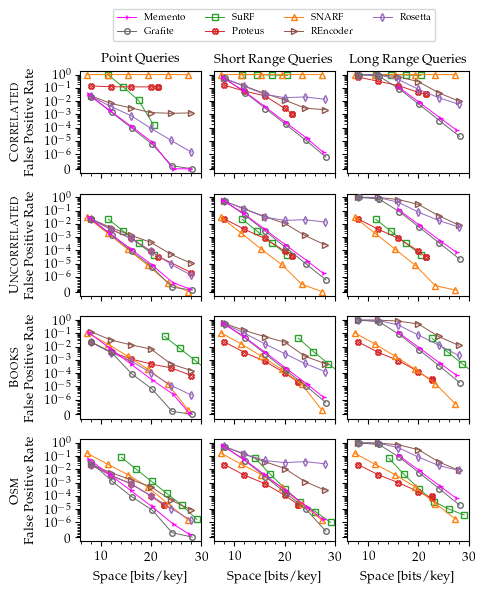

In [178]:
workloads = [('kuniform', 'qcorrelated'), ('kuniform', 'quniform'), ('books'), ('osm')]
range_filters = ['memento', 'grafite', 'surf', 'proteus', 'snarf', 'rencoder', 'rosetta']

print_fpr_test(range_filters, workloads, 'all')

In [50]:
df_list = generate_tables(range_filters, workloads)
with open(f'{out_folder}/table.tex', 'w') as f:
    for df in df_list:
        f.write(df.to_latex(index=False))
        f.write("\n\n")

## Input Size vs Construction Time

In [32]:
size_test_path = f'{base_csv_path}/constr_time_test'

sorted_dirs = sorted(os.listdir(size_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

size_test_path = Path(size_test_path + '/' + sorted_dirs[0])

keys_size = [5, 6, 7, 8]
labels_keys_size = [f'$10^{x}$' for x in keys_size]

matplotlib.rcParams['hatch.linewidth'] = 0.1

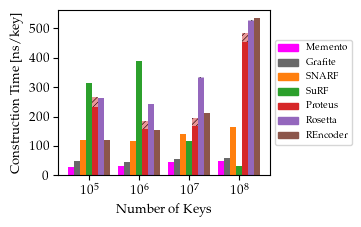

In [63]:
old_range_filters = range_filters
range_filters = ['memento', 'grafite', 'snarf', 'surf', 'proteus', 'rosetta', 'rencoder']
range_filter_labels = ['Memento', 'Grafite', 'SNARF', 'SuRF', 'Proteus', 'Rosetta', 'REncoder']

fig, ax = plt.subplots(figsize=(width_small * 0.78, 0.3 * width))

width_bars = 0.12  # Width of the bars
multiplier = 0

iterate = list(itertools.product(keys_size, range_filters))
for (r, ds) in iterate:
    i = r - min(keys_size)
    data = pd.read_csv(get_file(ds, 5, f'kuniform_{r}', query_name='quniform', path=size_test_path))
    if data.empty or data["build_time"].empty: continue

    if "modelling_time" in data.columns:
        build_time = np.mean(data['build_time'])/data['n_keys'] * 10**6
        modelling_time = np.mean(data['modelling_time'])/data['n_keys'] * 10**6
        ax.bar(range_filters.index(ds) * width_bars + i, build_time, width_bars, color=range_filters_style_kwargs[ds]['color'])
        ax.bar(range_filters.index(ds) * width_bars + i, modelling_time, width_bars, label='_nolegend_', bottom=build_time, color=range_filters_style_kwargs[ds]['color'], alpha=0.1, hatch='//////')
    else:
        build_time = np.mean(data['build_time'])/data['n_keys'] * 10**6
        ax.bar(range_filters.index(ds) * width_bars + i, build_time, width_bars, color=range_filters_style_kwargs[ds]['color'])

ax.set_ylabel('Construction Time [ns/key]', fontsize=ylabel_font_size)
ax.legend([range_filters_style_kwargs[ds]['label'] for ds in range_filters], loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)
ax.set_xticks(np.arange(len(keys_size)) + 3 * width_bars, labels_keys_size)
ax.set_xlabel('Number of Keys', fontsize=xlabel_font_size)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(100))

leg = ax.get_legend()
for ds, label in zip(range_filters, range_filter_labels):
    leg.legend_handles[range_filters.index(ds)].set_color(range_filters_style_kwargs[ds]['color'])

fig.savefig(f'{out_folder}/constr_time_test.pdf', bbox_inches='tight', pad_inches=0.01)
range_filters = old_range_filters

## Memory vs. Query Time (Non-Empty Queries)

In [44]:
true_test_path = f'{base_csv_path}/true_test'

sorted_dirs = sorted(os.listdir(true_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

true_test_path = Path(true_test_path + '/' + sorted_dirs[0])

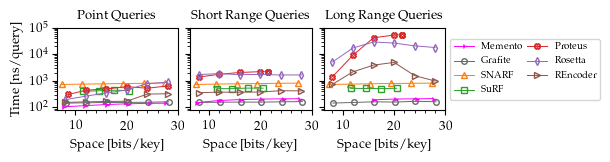

In [46]:
keys_synth = ['kuniform']
nrows = len(keys_synth)
ncols = len(query_range)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(width * 0.7, 0.15 * width))

iterate = list(itertools.product(range_filters, enumerate(query_range)))

for (ds, r) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, r[1], 'kuniform', 'qtrue', true_test_path))
    data["single_query_time"] = (data["query_time"] / data["n_queries"]) * 10**6
    data.plot("bpk", "single_query_time", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)

ticks = [10**2, 10**3, 10**4, 10**5]

for ax in axes.flatten():
    ax.set_xlim(right=max_x_axis_bpk)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
    ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
    ax.set_yscale('log')
    ax.get_legend().remove()
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
    ax.set_yticks(ticks)

for i, k in list(enumerate(keys_synth)):
    axis_title = f'{k}'
    axes[i].set_ylabel("Time [ns/query]", fontsize=ylabel_font_size)
    
for i, _ in list(enumerate(query_range)):
    axes[i].set_title(query_range_label[i], fontsize=title_font_size)
    
fig.subplots_adjust(wspace=0.1)
fig.savefig(f'{out_folder}/true_queries_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[2].get_position()
lines, labels = axes[0].get_legend_handles_labels()
# order = [0,1,5,2,6,3,7,4,8]
axes[2].legend(lines, labels, 
                  loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=False, ncol=2, fontsize=legend_font_size, columnspacing=0.5)

fig.savefig(f'{out_folder}/true_queries_test.pdf', bbox_inches='tight', pad_inches=0.01)

## Correlation vs. FPR

In [63]:
corr_test_path = f'{base_csv_path}/corr_test'

sorted_dirs = sorted(os.listdir(corr_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

corr_test_path = Path(corr_test_path + '/' + sorted_dirs[0])

corr_degrees = range(0, 11)

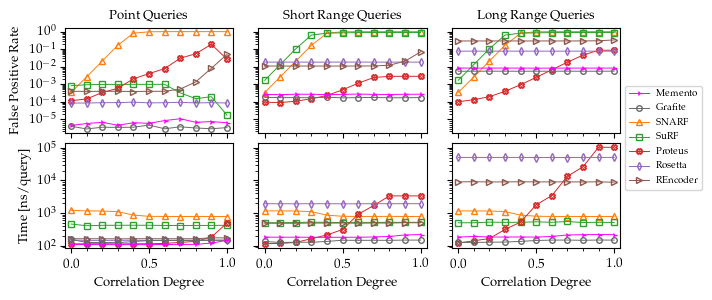

In [64]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=(width, 0.4 * width))

range_filters_corr = ['memento', 'grafite', 'snarf', 'surf', 'proteus', 'rosetta', 'rencoder']

iterate = list(itertools.product(range_filters_corr, enumerate(query_range), corr_degrees))

values = [dict() for x in range(len(query_range))]
time_values = [dict() for x in range(len(query_range))]

for ds in range_filters_corr:
    for r in range(len(query_range)):
        values[r][ds] = []
        time_values[r][ds] = []
        
xlabels_corr = [ x/10 for x in corr_degrees ]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, r[1], f'kuniform_{deg}', 'qcorrelated', corr_test_path))
    data['fpr_opt'] = data['false_positives'] / data['n_queries']
    fpr = data['fpr_opt'][0]
    time = data['query_time'][0]/data['n_queries'][0] * 10**6
    values[idx][ds].append(fpr)
    time_values[idx][ds].append(time)
    
for r in range(len(query_range)):
    for key, data_list in values[r].items():
        axes[0][r].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)
            
for r in range(len(query_range)):
    for key, data_list in time_values[r].items():
        axes[1][r].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)   
    axes[1][r].set_yscale('log')
    
axes[1][0].set_ylabel('Time [ns/query]', fontsize=ylabel_font_size)

for ax in axes.flatten():
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e-05))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
    
for ax in axes[1].flatten():
    ax.set_xlabel('Correlation Degree', fontsize=xlabel_font_size)
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
    
for i, _ in list(enumerate(query_range)):
    axes[0][i].set_title(query_range_label[i], fontsize=xlabel_font_size)
plt.subplots_adjust(hspace=0.1, wspace=0.15)
axes[0][0].set_ylabel('False Positive Rate', fontsize=ylabel_font_size)
axes[0][0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))

plt.savefig(f'{out_folder}/corr_test_twolines_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[0][2].get_position()
lines, labels = axes[0][0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_corr)))
axes[0][2].legend([lines[idx] for idx in order],[labels[idx] for idx in order], 
                  loc='center left', bbox_to_anchor=(1, -0.05),
                  fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/corr_test_twolines.pdf', bbox_inches='tight', pad_inches=0.01)

## Correlation (Small)

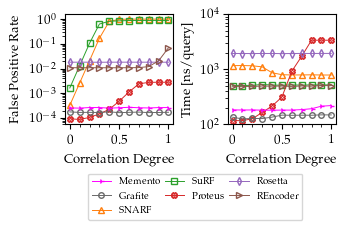

In [43]:
range_filters_corr = ['memento', 'grafite', 'snarf', 'surf', 'proteus', 'rosetta', 'rencoder']

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(width_small, 0.2 * width))
query_range_small = [5]

iterate = list(itertools.product(range_filters_corr, enumerate(query_range_small), corr_degrees))
values = [dict() for x in range(len(query_range_small))]
time_values = [dict() for x in range(len(query_range_small))]

for ds in range_filters_corr:
    for r in range(len(query_range_small)):
        values[r][ds] = []
        time_values[r][ds] = []
        
xlabels_corr = [ x/10 for x in corr_degrees ]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, r[1], f'kuniform_{deg}', 'qcorrelated', corr_test_path))
    data['fpr_opt'] = data['false_positives'] / data['n_queries']
    fpr = data['fpr'][0]
    time = data['query_time'][0]/data['n_queries'][0] * 10**6
    values[idx][ds].append(fpr)
    time_values[idx][ds].append(time)
    
for key, data_list in values[0].items():
    axes[0].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)
            
for key, data_list in time_values[0].items():
    axes[1].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)   
axes[1].set_yscale('log')

axes[1].set_ylabel('Time [ns/query]', fontsize=ylabel_font_size)
axes[1].set_ylim(10**2, 10**4)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel('Correlation Degree', fontsize=xlabel_font_size)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
    ax.set_xticks([0, 0.5, 1])

box = axes[1].get_position()
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = axes[1].get_legend_handles_labels()
axes[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=(-0.3, -0.4),
          fancybox=True, shadow=False, ncol=3, columnspacing=0.5, fontsize=legend_font_size)
axes[0].set_ylabel('False Positive Rate', fontsize=ylabel_font_size)
axes[0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
axes[0].set_yticks([1, 1e-01, 1e-02, 1e-03, 1e-04])
fig.align_ylabels([axes[0], axes[1]])

plt.subplots_adjust(wspace=0.5)
plt.savefig(f'{out_folder}/corr_test_small.pdf', bbox_inches='tight', pad_inches=0.01)

## Expandability

In [7]:
expansion_test_path = f'{base_csv_path}/expansion_test'

sorted_dirs = sorted(os.listdir(expansion_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

expansion_test_path = Path(expansion_test_path + '/' + sorted_dirs[0])

corr_degrees = range(0, 2)
N_EXPANSIONS = 7

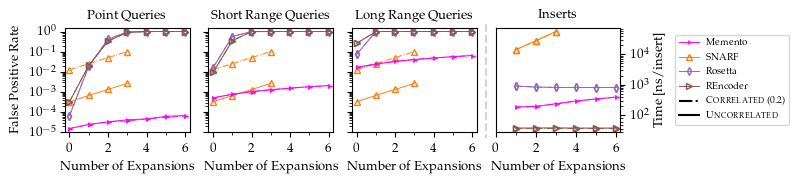

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(1 * width, 0.19 * width))
axes = fig.axes

fpr_insert_sep = matplotlib.lines.Line2D((0.7125, 0.7125), (0.91, 0.07), linestyle="--", color="lightgrey",
                                         transform=fig.transFigure)
fig.lines = fpr_insert_sep,

range_filters_exp = ['memento', 'snarf', 'rosetta', 'rencoder']

alt_lines_style = {'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': "-."}

exp_query_range = query_range
iterate = list(itertools.product(range_filters_exp, enumerate(exp_query_range), corr_degrees))
xlabels_expansion = [i for i in range(N_EXPANSIONS + 1)]

values = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]
exp_times = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, ran, f'kuniform_{deg}', 'qcorrelated', expansion_test_path))
    for i in range(N_EXPANSIONS):
        if f"false_positives_{i}" in data:
            values[deg][idx][ds].append(data[f"false_positives_{i}"] / data[f"n_queries_{i}"])
        if f"expansion_time_{i}" in data and f"n_keys_{i}" in data:
            exp_times[deg][idx][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}"] / 2) * 10 ** 6)

for deg in corr_degrees:
    for r in range(len(exp_query_range)):
        for key, data_list in values[deg][r].items():
            axes[r].plot(xlabels_expansion[:len(data_list)], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))
for deg in corr_degrees:
    for key, data_list in exp_times[deg][0].items():
        axes[-1].plot(xlabels_expansion[1:len(data_list) + 1], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))

for ax in axes:
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e-05))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
for ax in axes[1:3]:
    ax.set_ylim(axes[0].get_ylim())
    ax.set_yticklabels([])
axes[-1].set_yscale('symlog', linthresh=(1e02))
axes[-1].yaxis.set_label_position("right")
axes[-1].yaxis.tick_right()

for i, _ in list(enumerate(exp_query_range)):
    axes[i].set_title(query_range_label[i], fontsize=xlabel_font_size)
axes[-1].set_title("Inserts", fontsize=xlabel_font_size)
plt.subplots_adjust(hspace=0.1, wspace=0.15)

axes[0].set_ylabel('False Positive Rate', fontsize=ylabel_font_size)
axes[-1].set_ylabel('Time [ns/insert]', fontsize=ylabel_font_size)
for ax in axes:
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))

for i in range(len(exp_query_range) + 1):
    axes[i].set_xlabel('Number of Expansions', fontsize=ylabel_font_size)
    axes[i].set_xticks([0, 2, 4, 6])

plt.savefig(f'{out_folder}/expansion_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[-1].get_position()
lines, labels = axes[0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_exp)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["\\textsc{Correlated} (0.2)", "\\textsc{Uncorrelated}"]
axes[-1].legend([lines[idx] for idx in order] + legend_lines, [labels[idx] for idx in order] + legend_line_labels, 
                loc='center left', bbox_to_anchor=(1.4, 0.5),
                fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/expansion_test.pdf', bbox_inches='tight', pad_inches=0.01)

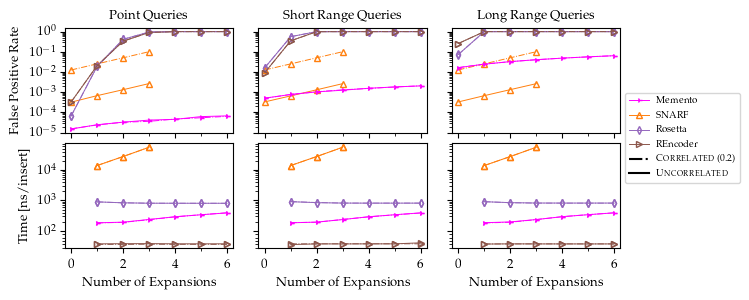

In [48]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=(width, 0.4 * width))

range_filters_exp = ['memento', 'snarf', 'rosetta', 'rencoder']

alt_lines_style = {'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': "-."}

exp_query_range = query_range
iterate = list(itertools.product(range_filters_exp, enumerate(exp_query_range), corr_degrees))
xlabels_expansion = [i for i in range(N_EXPANSIONS + 1)]

values = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]
exp_times = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, ran, f'kuniform_{deg}', 'qcorrelated', expansion_test_path))
    for i in range(N_EXPANSIONS):
        if f"false_positives_{i}" in data:
            values[deg][idx][ds].append(data[f"false_positives_{i}"] / data[f"n_queries_{i}"])
        if f"expansion_time_{i}" in data and f"n_keys_{i}" in data:
            exp_times[deg][idx][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}"] / 2) * 10 ** 6)

for deg in corr_degrees:
    for r in range(len(exp_query_range)):
        for key, data_list in values[deg][r].items():
            axes[0][r].plot(xlabels_expansion[:len(data_list)], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))
for deg in corr_degrees:
    for r in range(len(exp_query_range)):
        for key, data_list in exp_times[deg][r].items():
            axes[1][r].plot(xlabels_expansion[1:len(data_list) + 1], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))
            
for ax in axes[0].flatten():
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e-05))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
for ax in axes[1].flatten():
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e02))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))

for i, _ in list(enumerate(exp_query_range)):
    axes[0][i].set_title(query_range_label[i], fontsize=xlabel_font_size)
plt.subplots_adjust(hspace=0.1, wspace=0.15)
for i in range(2):
    axes[i][0].set_ylabel('False Positive Rate' if i % 2 == 0 else 'Time [ns/insert]', fontsize=ylabel_font_size)
    axes[i][0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
for i in range(len(exp_query_range)):
    axes[1][i].set_xlabel('Number of Expansions', fontsize=ylabel_font_size)

plt.savefig(f'{out_folder}/expansion_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[0][2].get_position()
lines, labels = axes[0][0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_exp)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["\\textsc{Correlated} (0.2)", "\\textsc{Uncorrelated}"]
axes[0][2].legend([lines[idx] for idx in order] + legend_lines, [labels[idx] for idx in order] + legend_line_labels, 
                  loc='center left', bbox_to_anchor=(1, -0.05),
                  fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/expansion_test.pdf', bbox_inches='tight', pad_inches=0.01)

## B-Tree

In [7]:
b_tree_test_path = f'{base_csv_path}/b_tree_test'

sorted_dirs = sorted(os.listdir(b_tree_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

b_tree_test_path = Path(b_tree_test_path + '/' + sorted_dirs[0])

datasets = [("kuniform", "quniform"), ("knormal", "qnormal")]
N_EXPANSIONS = 3
N_FRACS = 11
width = 6
ylabel_font_size = 12
legend_font_size = 10

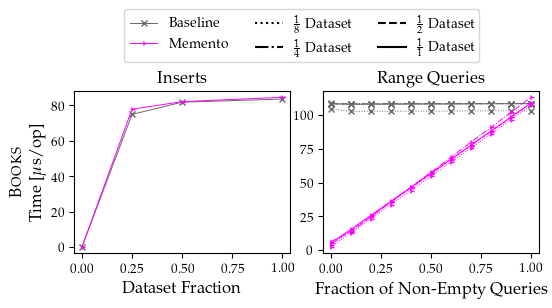

In [8]:
datasets = [("kuniform", "quniform")]
# datasets = [("books_expansion", "")]
# Expansion
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(width, 0.35 * width))

range_filters_b_tree = ['none', 'memento']

alt_lines_styles = [{'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': x} for x in [":", "-.", "--", "-"]]

b_tree_query_range = ["5M"]
iterate = list(itertools.product(range_filters_b_tree, b_tree_query_range, enumerate(datasets)))

write_values = [[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for dist in datasets]
read_values = [[[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for exp in range(N_EXPANSIONS + 1)] for dist in datasets]
xlabels_expansion = [(2 ** i) / 8 for i in range(N_EXPANSIONS + 1)]
xlabels_fraction = [i / (N_FRACS - 1) for i in range(N_FRACS)]

for (ds, ran, (idx, (k_dist, q_dist))) in iterate:
    data = pd.read_csv(get_file(ds, ran, k_dist, q_dist, b_tree_test_path))
    for i in range(N_EXPANSIONS + 1):
        if f"expansion_time_{i}" in data:
            write_values[idx][0][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}_frac_0"]) / 2 * 10 ** 3)
        else:
            write_values[idx][0][ds].append(data[f"build_time"] * 0)
        for j in range(N_FRACS):
            if f"query_time_{i}_frac_{j}" in data:
                read_values[idx][i][0][ds].append(data[f"query_time_{i}_frac_{j}"] / data[f"n_queries_{i}_frac_{j}"] * 10 ** 3)

for ind, (key_set, query_set) in enumerate(datasets):
    for key, data_list in write_values[ind][0].items():
        axes[0].plot([0, ] + xlabels_expansion[1:len(data_list) + 1], data_list, **b_tree_range_filters_style_kwargs[key], **lines_style)
    for i in range(N_EXPANSIONS + 1):
        for key, data_list in read_values[ind][i][0].items():
            axes[1].plot(xlabels_fraction[:len(data_list)], data_list, **b_tree_range_filters_style_kwargs[key], **alt_lines_styles[i])
            
for ax in axes.flatten():
    ax.margins(0.04)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    
plt.subplots_adjust(hspace=0.15, wspace=0.15)
for i in range(len(datasets)):
    axes[0].set_ylabel(f"{labels_name['books']}\nTime [$\\mu$s/op]", fontsize=ylabel_font_size)
axes[0].set_title("Inserts", fontsize=ylabel_font_size)
axes[1].set_title("Range Queries", fontsize=ylabel_font_size)
axes[0].set_xlabel('Dataset Fraction', fontsize=ylabel_font_size)
axes[1].set_xlabel('Fraction of Non-Empty Queries', fontsize=ylabel_font_size)

plt.savefig(f'{out_folder}/b_tree_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[1].get_position()
lines, labels = axes[0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_b_tree)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle=":"),
                mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="--"),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["$\\frac{1}{" + str(2 ** (3 - i)) + "}$ Dataset" for i in range(N_EXPANSIONS + 1)]
axes[1].legend([lines[idx] for idx in order] + legend_lines,[labels[idx] for idx in order] + legend_line_labels, 
                loc='upper left', bbox_to_anchor=(-0.95, 1.55),
                fancybox=True, shadow=False, ncol=3, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/b_tree_test.pdf', bbox_inches='tight', pad_inches=0.05)

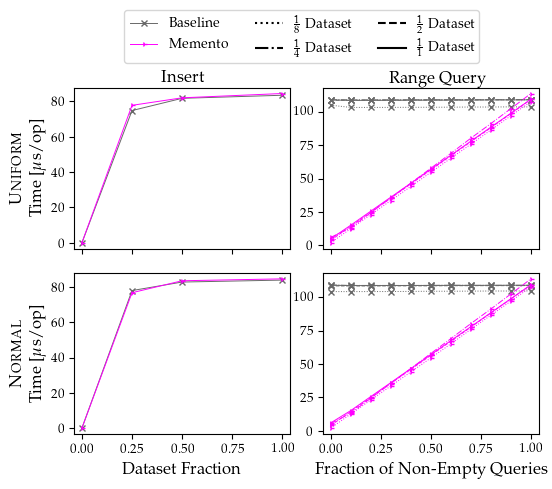

In [131]:
# Expansion
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(width, 0.75 * width))

range_filters_b_tree = ['none', 'memento']

alt_lines_styles = [{'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': x} for x in [":", "-.", "--", "-"]]

b_tree_query_range = ["5M"]
iterate = list(itertools.product(range_filters_b_tree, b_tree_query_range, enumerate(datasets)))

write_values = [[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for dist in datasets]
read_values = [[[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for exp in range(N_EXPANSIONS + 1)] for dist in datasets]
xlabels_expansion = [(2 ** i) / 8 for i in range(N_EXPANSIONS + 1)]
xlabels_fraction = [i / (N_FRACS - 1) for i in range(N_FRACS)]

for (ds, ran, (idx, (k_dist, q_dist))) in iterate:
    data = pd.read_csv(get_file(ds, ran, k_dist, q_dist, b_tree_test_path))
    for i in range(N_EXPANSIONS + 1):
        if f"expansion_time_{i}" in data:
            write_values[idx][0][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}_frac_0"]) / 2 * 10 ** 3)
        else:
            write_values[idx][0][ds].append(data[f"build_time"] * 0)
        for j in range(N_FRACS):
            if f"query_time_{i}_frac_{j}" in data:
                else:
                    read_values[idx][i][0][ds].append(data[f"query_time_{i}_frac_{j}"] / data[f"n_queries_{i}_frac_{j}"] * 10 ** 3)

for ind, (key_set, query_set) in enumerate(datasets):
    for key, data_list in write_values[ind][0].items():
        axes[ind][0].plot([0, ] + xlabels_expansion[1:len(data_list) + 1], data_list, **b_tree_range_filters_style_kwargs[key], **lines_style)
    for i in range(N_EXPANSIONS + 1):
        for key, data_list in read_values[ind][i][0].items():
            axes[ind][1].plot(xlabels_fraction[:len(data_list)], data_list, **b_tree_range_filters_style_kwargs[key], **alt_lines_styles[i])
            
for ax in axes.flatten():
    ax.margins(0.04)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    
plt.subplots_adjust(hspace=0.15, wspace=0.15)
for i in range(len(datasets)):
    axes[i][0].set_ylabel(labels_name[datasets[i][0]] + "\nTime [$\\mu$s/op]", fontsize=ylabel_font_size)
axes[0].set_title("Inserts", fontsize=ylabel_font_size)
axes[1].set_title("Range Queries", fontsize=ylabel_font_size)
axes[1][0].set_xlabel('Dataset Fraction', fontsize=ylabel_font_size)
axes[1][1].set_xlabel('Fraction of Non-Empty Queries', fontsize=ylabel_font_size)

plt.savefig(f'{out_folder}/expansion_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[0][1].get_position()
lines, labels = axes[0][0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_b_tree)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle=":"),
                mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="--"),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["$\\frac{1}{" + str(2 ** (3 - i)) + "}$ Dataset" for i in range(N_EXPANSIONS + 1)]
axes[0][1].legend([lines[idx] for idx in order] + legend_lines,[labels[idx] for idx in order] + legend_line_labels, 
                  loc='upper left', bbox_to_anchor=(-0.95, 1.525),
                  fancybox=True, shadow=False, ncol=3, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/b_tree_test.pdf', bbox_inches='tight', pad_inches=0.05)